In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForLanguageModeling
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import h5py
import pickle

In [2]:
MAX_SIZE = 8000

In [3]:
model = AutoModelForCausalLM.from_pretrained('/data/avishnevskiy/experiments/dpo_btlm-20231103-071330/LATEST/', trust_remote_code=True).cuda()
tokenizer = AutoTokenizer.from_pretrained('cerebras/btlm-3b-8k-base')
tokenizer.pad_token = tokenizer.eos_token
loss = torch.nn.CrossEntropyLoss()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# datasetA = load_dataset('DKYoon/SlimPajama-6B', split='validation', cache_dir="/data/avishnevskiy/.cache/hf")
dataset = load_dataset('DKYoon/SlimPajama-6B', split='test', cache_dir='/data/avishnevskiy/.cache/hf')
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Found cached dataset parquet (/data/avishnevskiy/.cache/hf/DKYoon___parquet/DKYoon--SlimPajama-6B-1735e67c45f712b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [5]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_SIZE)

dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)
data_loader = DataLoader(dataset, collate_fn=data_collator, batch_size = 1, shuffle=False)

Loading cached processed dataset at /data/avishnevskiy/.cache/hf/DKYoon___parquet/DKYoon--SlimPajama-6B-1735e67c45f712b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f59fbafd22d793b8.arrow


In [6]:
def move_to_gpu(batch):
    return {k: v.cuda() for k, v in batch.items()}

In [7]:
attentions, logits, loss = [], [], []
model.eval()

# file_name = 'losses_logits.hdf5'
# counter = 0

for batch in tqdm(data_loader):
    with torch.no_grad():
        output = model(**move_to_gpu(batch))
        loss.append(output.loss.cpu().numpy())
        # logits.append(output.logits.cpu().numpy())

100%|██████████| 9346/9346 [1:14:23<00:00,  2.09it/s]  


In [9]:
import numpy as np
concatenated = np.concatenate([np.array([arr.item()]) for arr in loss])

In [20]:
concatenated

array([2.03005433, 2.57221532, 3.36437559, ..., 2.46116853, 2.62099862,
       1.52710521])

In [10]:
np.save('../files/btlm_0.05.npy', concatenated)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# btlm_loss = np.load('../files/btlm_loss.npy')
btlm_01_loss = np.load('../files/btlm_shp_0.1.npy')
btlm_03_loss = np.load('../files/btlm_shp_0.3.npy')
# btlm_05_loss = np.load('../files/btlm_0.5.npy')

In [8]:
btlm_loss = [sum(btlm_loss[i:i+100])/100 for i in range(0, len(btlm_loss), 100)]
btlm_01_loss = [sum(btlm_01_loss[i:i+100])/100 for i in range(0, len(btlm_01_loss), 100)]
btlm_03_loss = [sum(btlm_03_loss[i:i+100])/100 for i in range(0, len(btlm_03_loss), 100)]
btlm_05_loss = [sum(btlm_05_loss[i:i+100])/100 for i in range(0, len(btlm_05_loss), 100)]

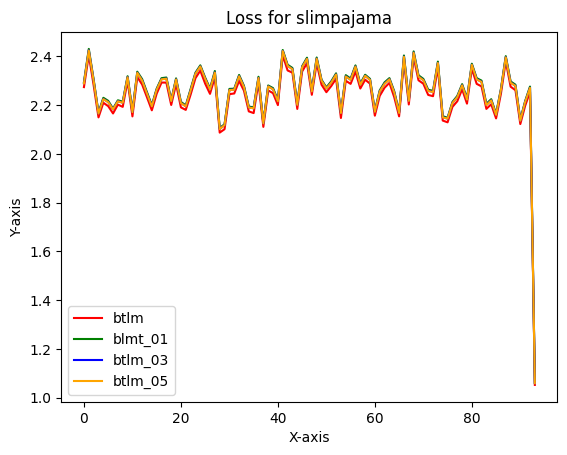

In [9]:
plt.plot(btlm_loss, label='btlm', color='red')
plt.plot(btlm_01_loss, label='blmt_01', color='green')
plt.plot(btlm_03_loss, label='btlm_03', color='blue')
plt.plot(btlm_05_loss, label='btlm_05', color='orange')

plt.title("Loss for slimpajama")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.legend()
plt.show()

In [11]:
sum(concatenated)/len(concatenated)

2.27928236089033

In [13]:
sum(btlm_01_loss)/len(btlm_01_loss)

2.263823979697434

In [15]:
sum(btlm_03_loss)/len(btlm_03_loss)

2.25803357304273

In [6]:
sum(btlm_05_loss)/len(btlm_05_loss)

2.2678179462381918

In [7]:
sum(btlm_shp_01_loss)/len(btlm_shp_01_loss)

2.263823979697434